# 210904 FastANI

In [1]:
from pathlib import Path
import json
from subprocess import run, PIPE

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import h5py as h5

## Setup

In [3]:
DATESTR = '210904'
NBNAME = DATESTR + '-fastani'

In [4]:
FASTANI_CMD = '/home/jared/opt/anaconda3/envs/fastani/bin/fastANI'

In [5]:
NTHREADS = 12

### Paths

In [6]:
infiles = dict(
    genomes=Path('data-intermediate/210902-get-genomes/genomes.csv'),
)

In [7]:
tmpdir = Path('tmp')

fastani_dir = tmpdir / 'fastani'
fastani_dir.mkdir(exist_ok=True)

In [8]:
intermediate_out = Path('data-intermediate') / NBNAME
intermediate_out.mkdir(exist_ok=True)

## Load data

In [9]:
genomes = pd.read_csv(infiles['genomes'], index_col='index')

In [10]:
ngenomes = genomes.shape[0]

In [11]:
genome_files = [tmpdir / 'genomes' / (acc + '.fa.gz') for acc in genomes['assembly_accession']]

## Chunk genomes

In [12]:
CHUNKSIZE = 20

In [13]:
chunks = [range(i, min(i + CHUNKSIZE, ngenomes)) for i in range(0, ngenomes, CHUNKSIZE)]
nchunks = len(chunks)
nchunks

25

In [14]:
chunkdir = fastani_dir / 'chunks'
chunkdir.mkdir(exist_ok=True)

In [15]:
chunk_files = [chunkdir / f'{i}.txt' for i in range(nchunks)]

for file, chunk in zip(chunk_files, chunks):
    with open(file, 'w') as f:
        for i in chunk:
            print(genome_files[i], file=f)

## Calculate pairwise ANIs

In [16]:
results_dir = fastani_dir / 'results'
results_dir.mkdir(exist_ok=True)

In [17]:
result_files = {(i, j): results_dir / f'{i}-{j}.tsv' for i in range(nchunks) for j in range(nchunks)}

In [18]:
_to_calculate = [(i, j, file) for (i, j), file in result_files.items() if not file.is_file()]

for i, j, file in tqdm(_to_calculate):
    if file.is_file():
        continue

    cmd = [
        FASTANI_CMD,
        '-t', NTHREADS,
        '--rl', chunk_files[i],
        '--ql', chunk_files[j],
        '-o', file,
    ]
    cmd = list(map(str, cmd))
    
    result = run(cmd, stdout=PIPE, stderr=PIPE)
        
    try:
        result.check_returncode()
    except:
        file.unlink(missing_ok=True)
        print(result.stderr.decode('ascii'))
        raise

0it [00:00, ?it/s]


## Assemble data

In [19]:
def read_results(i, j):
    df = pd.read_csv(result_files[i, j], sep='\t', names=['query', 'reference', 'ani', 'mapped', 'query_fragments'])

    df.index = pd.MultiIndex.from_arrays(
        [
            [file_to_index[i][f] for f in df['reference']],
            [file_to_index[j][f] for f in df['query']],
        ],
        names=['r', 'q'],
    )
    
    return df

In [20]:
file_to_index = [{str(genome_files[gi]): gi for gi in chunk} for chunk in chunks]

In [21]:
ani = np.full((ngenomes, ngenomes), -1.)
mapped = np.full((ngenomes, ngenomes), -1)
query_fragments = np.full(ngenomes, -1)

In [22]:
for (i, j), file in tqdm(result_files.items()):
    if not file.is_file():
        continue

    df = read_results(i, j)
    
    for q, sdf in df.groupby('q'):
        rs = sdf.index.get_level_values('r').values
        ani[rs, q] = sdf['ani'] / 100
        mapped[rs, q] = sdf['mapped']
        (query_fragments[q],) = sdf['query_fragments'].unique()

100%|██████████| 625/625 [00:07<00:00, 85.39it/s]


In [23]:
assert not np.any(ani < 0)
assert not np.any(mapped < 0)
assert not np.any(query_fragments < 0)

### Write to HDF5 file

In [24]:
assert mapped.max() <= np.iinfo(np.int16).max
assert query_fragments.max() <= np.iinfo(np.int16).max

In [25]:
with h5.File(str(intermediate_out / 'ani-matrix.h5'), 'w') as f:
    f.create_dataset('ani', dtype=np.float32, data=ani)
    f.create_dataset('mapped', dtype=np.int16, data=mapped)
    f.create_dataset('query_fragments', dtype=np.int16, data=query_fragments)

## Convert to pair format

In [26]:
genomes1 = []
genomes2 = []

for i in range(ngenomes):
    for j in range(i + 1):
        genomes1.append(i)
        genomes2.append(j)

In [27]:
ani_r1q2 = np.asarray([ani[g1, g2] for g1, g2 in zip(genomes1, genomes2)])
ani_r2q1 = np.asarray([ani[g2, g1] for g1, g2 in zip(genomes1, genomes2)])
ani_mean = (ani_r1q2 + ani_r2q1) / 2

mapped_r1q2 = np.asarray([mapped[g1, g2] for g1, g2 in zip(genomes1, genomes2)])
mapped_r2q1 = np.asarray([mapped[g2, g1] for g1, g2 in zip(genomes1, genomes2)])
mapped_mean = (mapped_r1q2 + mapped_r2q1) / 2

In [28]:
with h5.File(str(intermediate_out / 'ani-pairwise.h5'), 'w') as f:
    f.create_dataset('genome1', dtype=np.int16, data=genomes1)
    f.create_dataset('genome2', dtype=np.int16, data=genomes2)
    f.create_dataset('ani_r1q2', dtype=np.float32, data=ani_r1q2)
    f.create_dataset('ani_r2q1', dtype=np.float32, data=ani_r2q1)
    f.create_dataset('ani_mean', dtype=np.float32, data=ani_mean)
    f.create_dataset('mapped_r1q2', dtype=np.int16, data=mapped_r1q2)
    f.create_dataset('mapped_r2q1', dtype=np.int16, data=mapped_r2q1)
    f.create_dataset('mapped_mean', dtype=np.int16, data=mapped_mean)

## Inspect

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
f = (ani_r1q2 > 0) & (ani_r2q1 > 0)

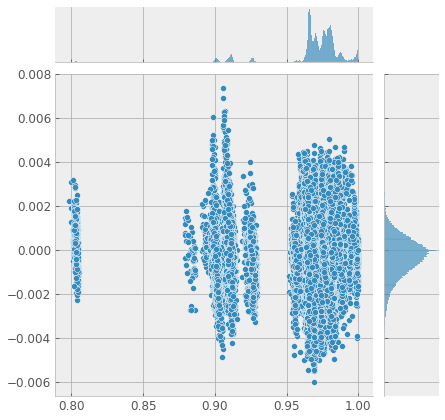

In [31]:
sns.jointplot(x=ani_r1q2[f], y=ani_r2q1[f] - ani_r1q2[f])

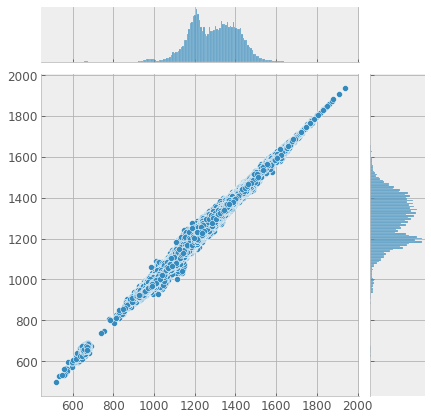

In [32]:
sns.jointplot(x=mapped_r1q2[f], y=mapped_r2q1[f])